In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer


from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier

In [105]:
df = pd.read_csv("Default.csv")
df

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138950
3,No,No,529.250605,35704.493940
4,No,No,785.655883,38463.495880
...,...,...,...,...
9995,No,No,711.555020,52992.378910
9996,No,No,757.962918,19660.721770
9997,No,No,845.411989,58636.156980
9998,No,No,1569.009053,36669.112360


In [106]:
df['default'] = df['default'].map({'Yes': 1, 'No': 0})
df['student'] = df['student'].map({'Yes': 1, 'No': 0})
df

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138950
3,0,0,529.250605,35704.493940
4,0,0,785.655883,38463.495880
...,...,...,...,...
9995,0,0,711.555020,52992.378910
9996,0,0,757.962918,19660.721770
9997,0,0,845.411989,58636.156980
9998,0,0,1569.009053,36669.112360


In [107]:
x = df.drop(columns="default")
y = df["default"]

In [108]:
numerical_features = ["balance", "income"]
categorical_features = ["student"]

model = DecisionTreeClassifier(random_state=42)

In [109]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('model', model)
])

pipeline.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance', 'income']),
                                                 ('cat', OneHotEncoder(),
                                                  ['student'])])),
                ('model', DecisionTreeClassifier(random_state=42))])

In [110]:
cv = 10
scores = cross_val_score(pipeline, x, y, scoring = "roc_auc_ovr", cv=cv)
auc = scores

auc_mean = auc.mean()
auc_std = auc.std()

print(auc_mean, auc_std)

0.6536315476523942 0.028483442831574276


In [111]:
y_score = pipeline.predict_proba(x)

lb = LabelBinarizer()
y_onehot = lb.fit_transform(y)
y_onehot = np.hstack([1 - y_onehot, y_onehot])

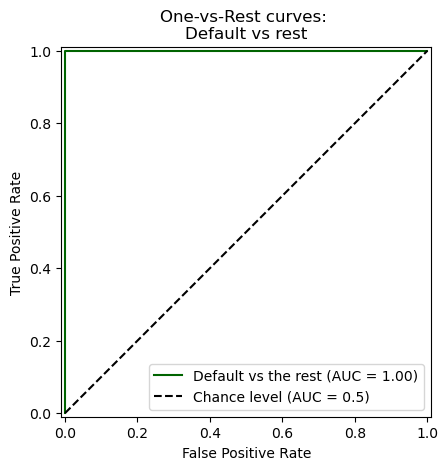

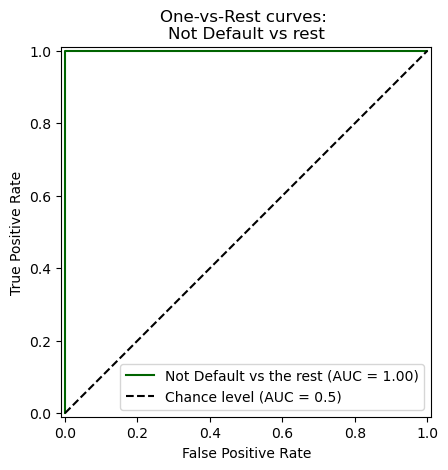

In [112]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

names = ["Default", "Not Default"]

classes = [0, 1]
for class_of_interest in classes:
    
    class_id = np.flatnonzero(lb.classes_ == class_of_interest)[0]
    display = RocCurveDisplay.from_predictions(
        y_onehot[:, class_id],
        y_score[:, class_id],
        name = f"{names[class_of_interest]} vs the rest",
        color = "darkgreen",
        plot_chance_level = True
    )
    _ = display.ax_.set(
        xlabel = "False Positive Rate",
        ylabel = "True Positive Rate",
        title = "One-vs-Rest curves: \n" + str(names[class_of_interest]) + " vs rest",
    )

### RANDOM FOREST

In [113]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

In [114]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('model', model)
])

pipeline.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance', 'income']),
                                                 ('cat', OneHotEncoder(),
                                                  ['student'])])),
                ('model', RandomForestClassifier())])

In [115]:
cv = 10
scores = cross_val_score(pipeline, x, y, scoring = "roc_auc_ovr", cv=cv)
auc = scores

auc_mean = auc.mean()
auc_std = auc.std()

print(auc_mean, auc_std)

0.886098631015081 0.02456316956612064


In [144]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# Assuming x and y are already defined
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)

# Define the objective function
def objective(trial):
    # Hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 5, 40)
    max_depth = trial.suggest_int("max_depth", 2, 4)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,  # Fixed value
        random_state=42,
        n_jobs=-1
    )

    # Use cross-validation for a robust estimate
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="roc_auc_ovr")
    return scores.mean()

# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=300)

# Print best results
print("Best trial:")
trial = study.best_trial

print(f"  ROC AUC: {trial.value}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-07 17:43:33,466] A new study created in memory with name: no-name-cbe61703-a1b9-41f2-9511-7dc454fd486c
[I 2025-04-07 17:43:33,822] Trial 0 finished with value: 0.9092222596056793 and parameters: {'n_estimators': 10, 'max_depth': 3}. Best is trial 0 with value: 0.9092222596056793.
[I 2025-04-07 17:43:34,258] Trial 1 finished with value: 0.8821610479330687 and parameters: {'n_estimators': 20, 'max_depth': 2}. Best is trial 0 with value: 0.9092222596056793.
[I 2025-04-07 17:43:34,908] Trial 2 finished with value: 0.8771845995110243 and parameters: {'n_estimators': 40, 'max_depth': 2}. Best is trial 0 with value: 0.9092222596056793.
[I 2025-04-07 17:43:35,336] Trial 3 finished with value: 0.878396765583294 and parameters: {'n_estimators': 23, 'max_depth': 2}. Best is trial 0 with value: 0.9092222596056793.
[I 2025-04-07 17:43:35,618] Trial 4 finished with value: 0.9122075454769755 and parameters: {'n_estimators': 10, 'max_depth': 4}. Best is trial 4 with value: 0.912207545476975

Best trial:
  ROC AUC: 0.9139235807370522
  Best hyperparameters:
    n_estimators: 8
    max_depth: 4


In [145]:
model = RandomForestClassifier(
        n_estimators=8,
        max_depth=4, 
        random_state=42,
        n_jobs=-1
    )

In [146]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('model', model)
])

pipeline.fit(x, y)

y_score = pipeline.predict_proba(x)

lb = LabelBinarizer()
y_onehot = lb.fit_transform(y)
y_onehot = np.hstack([1 - y_onehot, y_onehot])



In [147]:
roc_auc = roc_auc_score(y, y_score[:,1])

In [148]:
roc_auc

0.9423199448543402